In [7]:
import pandas as pd
import numpy as np
import json

In [5]:
products = pd.read_csv("amazon_baby.csv")
products['review'].fillna('', inplace=True)

def remove_punctuation(text):
    import string
    table = str.maketrans({key: None for key in string.punctuation})
    return str(text).translate(table)

products['review_clean'] = products['review'].apply(remove_punctuation)

In [6]:
products = products[products['rating'] != 3].reset_index(drop=True)
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else 0)

In [10]:
with open("module-9-assignment-train-idx.json", 'r') as f:
    train_idx = json.load(f)
with open("module-9-assignment-test-idx.json", 'r') as f:
    test_idx = json.load(f)

In [16]:
train_data = products.iloc[train_idx, :].reset_index(drop=True)
test_data  = products.iloc[test_idx, :].reset_index(drop=True)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [19]:
type(train_matrix)

scipy.sparse.csr.csr_matrix

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [23]:
model.fit(X=train_matrix, y=train_data['sentiment'], n_jobs=-2, verbose=1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], 
                          y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.932295416367


In [26]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


In [27]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
      0       |        0        |  3788
      0       |        1        |  1453
      1       |        0        |   804
      1       |        1        | 27291


In [28]:
FP = 1453
FN = 804
100.*FP + 1.*FN

146104.0

In [29]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.949450320067


In [30]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.971382808329


In [50]:
threshold_values = np.linspace(0.5, 1, num=100, endpoint=False)
# print(threshold_values)
precision_all = []
recall_all = []
for t in threshold_values:
    precision_all.append(precision_score(y_true=test_data['sentiment'], 
                            y_pred=(model.predict_proba(test_matrix)[:, 1] > t)))
    recall_all.append(recall_score(y_true=test_data['sentiment'], 
                            y_pred=(model.predict_proba(test_matrix)[:, 1] > t)))

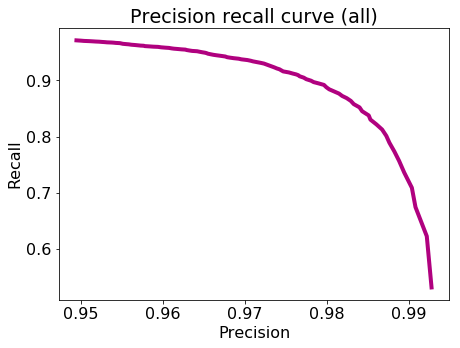

In [47]:
import matplotlib.pyplot as plt
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')
plt.show()

In [52]:
for (t, p, r) in zip(threshold_values, precision_all, recall_all):
    if p >= 0.965:
        print(t, p, r)
        break

0.71 0.965173949245 0.948958889482


In [54]:
confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict_proba(test_matrix)[:,1] >= 0.98,
                        labels=model.classes_)    # use the same order of class as the LR model.

array([[ 5047,   194],
       [ 8208, 19887]])

In [61]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [62]:
probabilities

array([ 0.78450224,  0.99999923,  0.99737052, ...,  0.93006453,
        0.99999999,  0.98176093])

In [63]:
threshold_values = np.linspace(0.5, 1, num=100, endpoint=False)
# print(threshold_values)
precision_all = []
recall_all = []
for t in threshold_values:
    precision_all.append(precision_score(y_true=baby_reviews['sentiment'], 
                            y_pred=(model.predict_proba(baby_matrix)[:, 1] > t)))
    recall_all.append(recall_score(y_true=baby_reviews['sentiment'], 
                            y_pred=(model.predict_proba(baby_matrix)[:, 1] > t)))

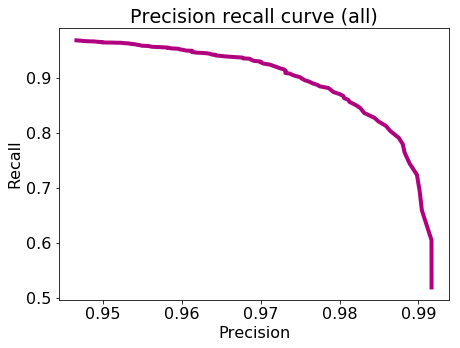

In [64]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')
plt.show()

In [65]:
for (t, p, r) in zip(threshold_values, precision_all, recall_all):
    if p >= 0.965:
        print(t, p, r)
        break

0.735 0.965588180288 0.938556626068
